# Implementation of Convolutional Variational AutoEncoder (CVAE)
    
     Author: Luu-Nguyen Van
     
     Email:  luu@gmail.com

# Prequiste

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.distributions.normal import Normal

# Model Hyperparameters

In [3]:
dataset_path = '~/datasets'

cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")

LR = 1e-3
IMAGE_SIZE = 32
BATCH_SIZE = 64
EMBEDDING_DIM = 2
EPOCHS = 100
SHAPE_BEFORE_FLATTENING = (128, IMAGE_SIZE // 8, IMAGE_SIZE // 8)

###    Step 1. Load (or download) Dataset

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        torchvision.transforms.Resize(32), transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=True, **kwargs)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 128MB/s]


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 33.9MB/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 45.0MB/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.64MB/s]


Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



### Step 2. Define model: Convolutional Variational AutoEncoder (CVAE)

**2.1. Define a class for sampling**

In [5]:
# This class will be used in the encoder for sampling in the latent space
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        # get the shape of the tensor for the mean and log variance
        batch, dim = z_mean.shape
        # generate a normal random tensor (epsilon) with the same shape as z_mean
        # this tensor will be used for reparameterization trick
        epsilon = Normal(0, 1).sample((batch, dim)).to(z_mean.device)
        # apply the reparameterization trick to generate the samples in the
        # latent space
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

**2.2. Implement Encoder**

In [6]:
class Encoder(nn.Module):
    def __init__(self, image_size, embedding_dim):
        super(Encoder, self).__init__()
        # define the convolutional layers for downsampling and feature extraction
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        # define a flatten layer to flatten the tensor before feeding it into the fully connected layer
        self.flatten = nn.Flatten()
        # define fully connected layers to transform the tensor into the desired embedding dimensions
        self.fc_mean = nn.Linear(128 * (image_size // 8) * (image_size // 8), embedding_dim)
        self.fc_log_var = nn.Linear(128 * (image_size // 8) * (image_size // 8), embedding_dim)
        # initialize the sampling layer
        self.sampling = Sampling()
    def forward(self, x):
        # apply convolutional layers with relu activation function
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # flatten the tensor
        x = self.flatten(x)
        # get the mean and log variance of the latent space distribution
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        # sample a latent vector using the reparameterization trick
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

**2.3. Implement Decoder**

In [7]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening):
        super(Decoder, self).__init__()
        # define a fully connected layer to transform the latent vector back to the shape before flattening
        self.fc = nn.Linear(embedding_dim, shape_before_flattening[0] * shape_before_flattening[1] * shape_before_flattening[2])
        # define a reshape function to reshape the tensor back to its original shape
        self.reshape = lambda x: x.view(-1, *shape_before_flattening)
        # define the transposed convolutional layers for the decoder to upsample and generate the reconstructed image
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)
    def forward(self, x):
        # pass the latent vector through the fully connected layer
        x = self.fc(x)
        # reshape the tensor
        x = self.reshape(x)
        # apply transposed convolutional layers with relu activation function
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        # apply the final transposed convolutional layer with a sigmoid activation to generate the final output
        x = torch.sigmoid(self.deconv3(x))
        return x

**2.3. Implement model**

In [8]:
class Model(nn.Module):
    def __init__(self, encoder, decoder):
        super(Model, self).__init__()
        # initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        # pass the input through the encoder to get the latent vector
        z_mean, z_log_var, z = self.encoder(x)
        # pass the latent vector through the decoder to get the reconstructed image
        reconstruction = self.decoder(z)
        # return the mean, log variance and the reconstructed image
        return z_mean, z_log_var, reconstruction

In [9]:
# Instantiate the encoder and decoder models
encoder = Encoder(IMAGE_SIZE, EMBEDDING_DIM)
decoder = Decoder(EMBEDDING_DIM, SHAPE_BEFORE_FLATTENING)

# Pass the encoder and decoder to VAE class
model = Model(encoder=encoder, decoder=decoder).to(DEVICE)
print(model)
from torchsummary import summary
summary(model, (1, 32, 32))

Model(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc_mean): Linear(in_features=2048, out_features=2, bias=True)
    (fc_log_var): Linear(in_features=2048, out_features=2, bias=True)
    (sampling): Sampling()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=2048, bias=True)
    (deconv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)
----------------------------------------------------------------
        Layer (type)    

### Step 3. Define Loss function (reprod. loss) and optimizer

In [10]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=LR)

### Step 4. Train Convolutional Variational AutoEncoder (CVAE)

In [11]:
print("Start training VAE...")
# initialize the best validation loss as infinity
best_loss = float("inf")

model.train()

for epoch in range(EPOCHS):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)

        optimizer.zero_grad()

        mean, log_var, x_hat = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()
        # save best vae model weights based on validation loss
        if overall_loss < best_loss:
            best_loss = overall_loss
            torch.save(model.state_dict(), 'model_weights.pt')

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*BATCH_SIZE))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  248.51301317408348
	Epoch 2 complete! 	Average Loss:  218.10322022819722
	Epoch 3 complete! 	Average Loss:  212.6944215463091
	Epoch 4 complete! 	Average Loss:  210.05263604781925
	Epoch 5 complete! 	Average Loss:  208.25001946024858
	Epoch 6 complete! 	Average Loss:  206.87699919449227
	Epoch 7 complete! 	Average Loss:  205.85392396452588
	Epoch 8 complete! 	Average Loss:  205.01914326638268
	Epoch 9 complete! 	Average Loss:  204.385221980043
	Epoch 10 complete! 	Average Loss:  203.75346077315453
	Epoch 11 complete! 	Average Loss:  203.20021794012797
	Epoch 12 complete! 	Average Loss:  202.7216438203891
	Epoch 13 complete! 	Average Loss:  202.32507131244736
	Epoch 14 complete! 	Average Loss:  201.9035426153063
	Epoch 15 complete! 	Average Loss:  201.57391579708397
	Epoch 16 complete! 	Average Loss:  201.1577654485387
	Epoch 17 complete! 	Average Loss:  200.84707200285465
	Epoch 18 complete! 	Average Loss:  200.5908624980849
	Epo

KeyboardInterrupt: 

### Step 5. Generate images from test dataset

In [12]:
import matplotlib.pyplot as plt

In [13]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.to(DEVICE)

        _, _, x_hat = model(x)

        break

  0%|          | 0/157 [00:00<?, ?it/s]


In [14]:
def show_image(x, idx):
    x = x.view(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

**Original image**

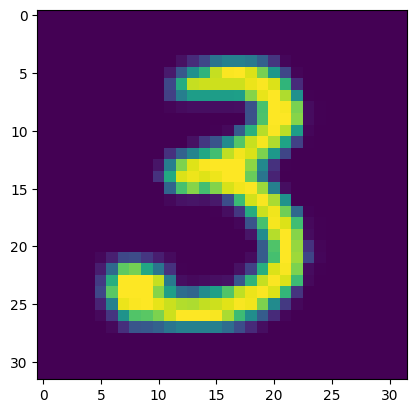

In [15]:
show_image(x, idx=11)

**Reconstruction image after going through the network**

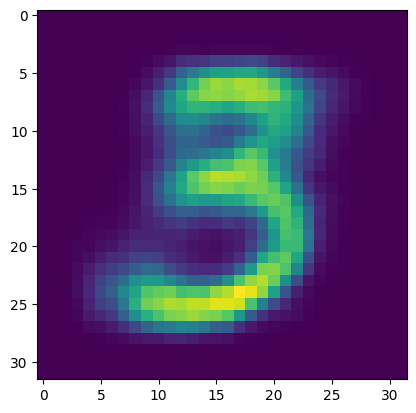

In [16]:
show_image(x_hat, idx=11)

# Print Weights and Output of each Layers information

In [30]:
# Load the weights from the specified file
model.load_state_dict(torch.load("/content/model_weights.pt"))
print("WEIGHTS:")
# Print weight information for each layer
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")
    weights = param.data
    min_weight = torch.min(weights)
    max_weight = torch.max(weights)
    print(f"Range - Min: {min_weight.item()}, Max: {max_weight.item()} \n")

# Initialize variables to store the overall minimum and maximum values for each layer
min_values = {}
max_values = {}
device = next(model.parameters()).device

def hook_fn(module, input, output):
    layer_name = module.__class__.__name__
    min_val = torch.min(output).item()
    max_val = torch.max(output).item()

    if layer_name not in min_values:
        min_values[layer_name] = min_val
        max_values[layer_name] = max_val
    else:
        min_values[layer_name] = min(min_values[layer_name], min_val)
        max_values[layer_name] = max(max_values[layer_name], max_val)

# Register forward hooks for Linear and Conv layers
for module in model.modules():
    if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
        module.register_forward_hook(hook_fn)

# Iterate over the test loader to trigger the hooks
for image, _ in test_loader:
    image = image.to(device)
    with torch.no_grad():
        _ = model(image)  # Perform a forward pass

print("\nOUTPUT:")
# Print the minimum and maximum values for each layer
for layer_name in min_values:
    print(f"Layer: {layer_name} | Min: {min_values[layer_name]}, Max: {max_values[layer_name]}")

WEIGHTS:
Layer: encoder.conv1.weight | Size: torch.Size([32, 1, 3, 3])
Range - Min: -1.9035922288894653, Max: 0.5418812036514282 

Layer: encoder.conv1.bias | Size: torch.Size([32])
Range - Min: -0.333332359790802, Max: 0.16348746418952942 

Layer: encoder.conv2.weight | Size: torch.Size([64, 32, 3, 3])
Range - Min: -0.8140051364898682, Max: 0.8200294375419617 

Layer: encoder.conv2.bias | Size: torch.Size([64])
Range - Min: -0.0926290825009346, Max: 0.11904893070459366 

Layer: encoder.conv3.weight | Size: torch.Size([128, 64, 3, 3])
Range - Min: -1.2458655834197998, Max: 0.4167528748512268 

Layer: encoder.conv3.bias | Size: torch.Size([128])
Range - Min: -0.08262688666582108, Max: 0.20946218073368073 

Layer: encoder.fc_mean.weight | Size: torch.Size([2, 2048])
Range - Min: -0.6522362232208252, Max: 0.721634566783905 

Layer: encoder.fc_mean.bias | Size: torch.Size([2])
Range - Min: -0.03896128013730049, Max: 0.0006666849949397147 

Layer: encoder.fc_log_var.weight | Size: torch.Siz

<ipython-input-30-c5ac7153f574>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/model_weights.pt"))



OUTPUT:
Layer: Conv2d | Min: -7.178086757659912, Max: 2.6956684589385986
Layer: Linear | Min: -9.192024230957031, Max: 4.810401439666748
Layer: ConvTranspose2d | Min: -113.92424774169922, Max: 70.95729064941406


### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training CVAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of CVAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [17]:
with torch.no_grad():
    noise = torch.randn(BATCH_SIZE, EMBEDDING_DIM).to(DEVICE)
    print(noise.shape)
    generated_images = decoder(noise)

torch.Size([64, 2])


In [18]:
save_image(generated_images.view(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE), 'generated_sample.png')

In [ ]:
show_image(generated_images, idx=0)

In [ ]:
show_image(generated_images, idx=1)

In [ ]:
show_image(generated_images, idx=10)

In [ ]:
show_image(generated_images, idx=20)

In [ ]:
show_image(generated_images, idx=50)

In [ ]:
show_image(generated_images, idx=62)